In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

# Data Loader

In [16]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Input, Add, Concatenate,\
    Bidirectional, SimpleRNN, LSTM, GRU
from nltk.stem import PorterStemmer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

ps = PorterStemmer()

In [3]:
def load_data(file_name):
    """
    :param file_name: a file name, type: str
    return a list of ids, a list of reviews, a list of stars
    """
    df = pd.read_csv(file_name)

    return df["review_id"], df["text"], df["stars"]

def load_test_data(file_name):
    """
    :param file_name: a file name, type: str
    return a list of labels
    """
    df = pd.read_csv(file_name)
    return df["review_id"], df["text"]

def write_predictions(file_name, pred):
    df = pd.DataFrame(zip(range(len(pred)), pred))
    df.columns = ["review_id", "stars"]
    df.to_csv(file_name, index=False)

# Feature Extractor

In [4]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    return [ps.stem(token).lower() for token in tokens]

def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>","<start>","<end>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>","<start>","<end>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    punctuation = ['.','?','!']
    vector = np.zeros(max_len, dtype=np.int64)
    idx = 0
    for i, f in enumerate(feats):
        if idx in [max_len-1,max_len]:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        if (i == 0) | ((i > 1) & (feats[i-1] in punctuation)):
            vector[idx] = feats_dict['<start>']
            idx += 1
            vector[idx] = feats_dict.get(f, 1)
        elif feats[i] in punctuation:
            vector[idx] = feats_dict.get(f, 1)
            idx += 1
            vector[idx] = feats_dict['<end>']
        else:
            vector[idx] = feats_dict.get(f, 1)        
        idx += 1
    return vector

# Read Data and Feature Engineering

In [5]:
train_file = "./data/train.csv"
val_file = "./data/valid.csv"
test_file = "./data/test.csv"

min_freq = 3

# load data
train_ids, train_texts, train_labels = load_data(train_file)
val_ids, val_texts, val_labels = load_data(val_file)
test_ids, test_texts = load_test_data(test_file)

# extract features
train_tokens = [tokenize(text) for text in train_texts]
val_tokens = [tokenize(text) for text in val_texts]
test_tokens = [tokenize(text) for text in test_texts]

train_stemmed = [stem(tokens) for tokens in train_tokens]
val_stemmed = [stem(tokens) for tokens in val_tokens]
test_stemmed = [stem(tokens) for tokens in test_tokens]

train_feats = train_stemmed
val_feats = val_stemmed
test_feats = test_stemmed

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=min_freq)

Size of features: 12786


In [6]:
# hyperparameter: max_sequence_length
max_len = 100

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
val_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in val_feats])
test_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in test_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
val_label_matrix = keras.utils.to_categorical(val_labels-1, num_classes=num_classes)

# RNN Architecture

In [7]:
def build_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",bidirectional=False, embedding_matrix=None,
              activation="tanh",dropout_rate=0.0,batch_norm=False,l2_reg=0.0,
              loss="categorical_crossentropy",optimizer="Adam",learning_rate=0.001,metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_rnn_layers: the number of layers of the RNN, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param rnn_type: the type of RNN, type: str
    :param bidirectional: whether to use bidirectional rnn, type: bool
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a RNN for text classification,
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    input_length=input_length,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable=False)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)
        if bidirectional:
            h = Bidirectional(fn(hidden_size,
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                 recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                 return_sequences=not is_last))(h)
        else:
            h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last)(h)
        h = Dropout(dropout_rate, seed=0)(h)
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation in FC layer
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

# RNN Models without Word Embedding

In [ ]:
os.makedirs("models", exist_ok=True)

# LSTM

In [27]:
np.random.seed(0)
tf.random.set_seed(0)

best_val_accuracy = 0.0
best_lstm_history = None
best_model = None

model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional=False, num_mlp_layers=2,
                  activation="relu",batch_norm=True,
                  learning_rate =0.001,l2_reg=0.008, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join("models", "lstm_weights.hdf5"),
                                                monitor="val_accuracy",verbose=0,save_best_only=True)
earlystopping = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1)

lstm_history = model.fit(train_feats_matrix, train_label_matrix,
                        epochs=100, batch_size=100, verbose=1,
                        callbacks=[checkpointer, earlystopping],
                       validation_data = (val_feats_matrix, val_label_matrix))
model = keras.models.load_model(os.path.join("models", "lstm_weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
val_score = model.evaluate(val_feats_matrix, val_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", val_score[0], "validation accuracy", val_score[1])

if val_score[1] > best_val_accuracy:
    best_val_accuracy = val_score[1]
    best_lstm_history = lstm_history
    best_model = model

Train on 20000 samples, validate on 2000 samples
Epoch 1/100
20000/20000 [==============================] - 52s 3ms/step - loss: 2.0543 - accuracy: 0.4369 - val_loss: 1.6496 - val_accuracy: 0.5075
Epoch 2/100
20000/20000 [==============================] - 55s 3ms/step - loss: 1.3248 - accuracy: 0.5634 - val_loss: 1.2148 - val_accuracy: 0.5890
Epoch 3/100
20000/20000 [==============================] - 53s 3ms/step - loss: 1.0505 - accuracy: 0.6157 - val_loss: 1.1367 - val_accuracy: 0.5820
Epoch 4/100
20000/20000 [==============================] - 54s 3ms/step - loss: 0.8885 - accuracy: 0.6629 - val_loss: 1.0871 - val_accuracy: 0.5450
Epoch 5/100
20000/20000 [==============================] - 57s 3ms/step - loss: 0.7971 - accuracy: 0.6934 - val_loss: 1.0587 - val_accuracy: 0.5760
Epoch 6/100
20000/20000 [==============================] - 48s 2ms/step - loss: 0.7301 - accuracy: 0.7180 - val_loss: 1.2342 - val_accuracy: 0.4930
Epoch 7/100
20000/20000 [==============================] - 50s 

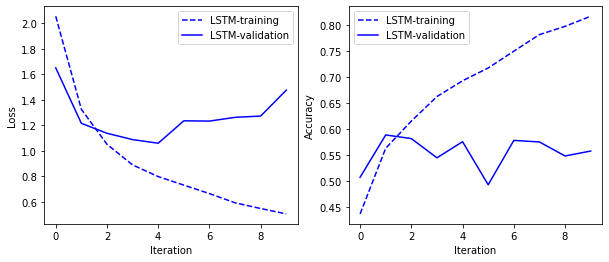

In [28]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(best_lstm_history.history["loss"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(best_lstm_history.history["val_loss"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(best_lstm_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(best_lstm_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

pre = pd.DataFrame({'review_id':val_ids})
pre['stars'] = np.argmax(best_model.predict(val_feats_matrix), axis = 1) + 1
pre.to_csv('./data/lstm_pred.csv', index=False)

ans = pd.read_csv("data/valid.csv", usecols=["review_id", "stars"])
pred = pd.read_csv("data/lstm_pred.csv", usecols=["review_id", "stars"])
df = pd.merge(ans, pred, how="left", on=["review_id"])
df.fillna(0, inplace=True)
acc = accuracy_score(df["stars_x"], df["stars_y"])
p, r, f1, _ = precision_recall_fscore_support(df["stars_x"], df["stars_y"], average="macro")
print("accuracy:", acc, "\tprecision:", p, "\trecall:", r, "\tf1:", f1)

accuracy: 0.589 	precision: 0.40540615311943845 	recall: 0.4639623396516292 	f1: 0.4249473235076742


# Bi-directional LSTM

In [33]:
np.random.seed(0)
tf.random.set_seed(0)

best_val_accuracy = 0.0
best_bi_lstm_history = None
best_model = None

model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional=True, num_mlp_layers=2,
                  activation="tanh",batch_norm=True,
                  learning_rate=0.002, l2_reg=0.015, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join("models", "bi_lstm_weights.hdf5"),
                                                monitor="val_accuracy",verbose=0,save_best_only=True)
earlystopping = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1)

bi_lstm_history = model.fit(train_feats_matrix, train_label_matrix,
                        epochs=100, batch_size=100, verbose=1,
                        callbacks=[checkpointer, earlystopping],
                       validation_data = (val_feats_matrix, val_label_matrix))
model = keras.models.load_model(os.path.join("models", "bi_lstm_weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
val_score = model.evaluate(val_feats_matrix, val_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", val_score[0], "test accuracy", val_score[1])

if val_score[1] > best_val_accuracy:
    best_val_accuracy = val_score[1]
    best_bi_lstm_history = bi_lstm_history
    best_model = model


Train on 20000 samples, validate on 2000 samples
Epoch 1/100
20000/20000 [==============================] - 116s 6ms/step - loss: 2.1009 - accuracy: 0.4802 - val_loss: 1.4555 - val_accuracy: 0.5230
Epoch 2/100
20000/20000 [==============================] - 116s 6ms/step - loss: 1.1353 - accuracy: 0.6202 - val_loss: 1.0836 - val_accuracy: 0.6060
Epoch 3/100
20000/20000 [==============================] - 123s 6ms/step - loss: 0.8900 - accuracy: 0.6698 - val_loss: 1.0480 - val_accuracy: 0.6060
Epoch 4/100
20000/20000 [==============================] - 111s 6ms/step - loss: 0.7681 - accuracy: 0.7090 - val_loss: 1.1528 - val_accuracy: 0.5665
Epoch 5/100
20000/20000 [==============================] - 113s 6ms/step - loss: 0.6700 - accuracy: 0.7469 - val_loss: 1.1796 - val_accuracy: 0.5560
Epoch 6/100
20000/20000 [==============================] - 120s 6ms/step - loss: 0.5752 - accuracy: 0.7842 - val_loss: 1.2091 - val_accuracy: 0.5755
Epoch 7/100
20000/20000 [==============================] 

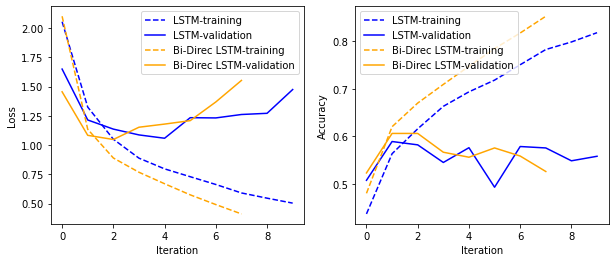

In [34]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(best_lstm_history.history["loss"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(best_lstm_history.history["val_loss"], label="LSTM-validation", color="blue")
plt.plot(best_bi_lstm_history.history["loss"], label="Bi-Direc LSTM-training", color="orange", linestyle="dashed")
plt.plot(best_bi_lstm_history.history["val_loss"], label="Bi-Direc LSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(best_lstm_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(best_lstm_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.plot(best_bi_lstm_history.history["accuracy"], label="Bi-Direc LSTM-training", color="orange", linestyle="dashed")
plt.plot(best_bi_lstm_history.history["val_accuracy"], label="Bi-Direc LSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [35]:


pre = pd.DataFrame({'review_id':val_ids})
pre['stars'] = np.argmax(best_model.predict(val_feats_matrix), axis = 1) + 1
pre.to_csv('./data/bilstm_pred.csv', index=False)

ans = pd.read_csv("data/valid.csv", usecols=["review_id", "stars"])
pred = pd.read_csv("data/bilstm_pred.csv", usecols=["review_id", "stars"])
df = pd.merge(ans, pred, how="left", on=["review_id"])
df.fillna(0, inplace=True)
acc = accuracy_score(df["stars_x"], df["stars_y"])
p, r, f1, _ = precision_recall_fscore_support(df["stars_x"], df["stars_y"], average="macro")
print("accuracy:", acc, "\tprecision:", p, "\trecall:", r, "\tf1:", f1)

accuracy: 0.606 	precision: 0.417405360479131 	recall: 0.45718946777271274 	f1: 0.4327963443779135


# Word2Vec

Save train_text, val_text and test_text to reviews.json where each line is a review. Replace the words in reviews that are not found in feats_dict with unknown token.Add tokens at the beginning and end of each sentence before word embedding.

In [8]:
def sentence_token(x, feats_dict):
    '''
    x is a list of words in a document
    add <start> and <end> token to indicate beginning and end of a sentence
    replace unknown words with <unk> token
    '''
    sent = []
    punctuation = ['.','?','!']
    sent.append('<start>')
    for w in x:
        if w in feats_dict:
            sent.append(w)
            if w in punctuation:
                sent.append('<end>')
                sent.append('<start>')
        else:
            sent.append('<unk>')
    return sent

In [9]:
with open("./data/reviews.txt", "w", encoding="utf-8") as f:
    for x in train_stemmed:
        sent = sentence_token(x, feats_dict)
        f.write(" ".join(sent))
        f.write("\n")
    for x in val_stemmed:
        sent = sentence_token(x, feats_dict)
        f.write(" ".join(sent))
        f.write("\n")
    for x in test_stemmed:
        sent = sentence_token(x, feats_dict)
        f.write(" ".join(sent))
        f.write("\n")

Then download the fastText and run the skip-gram algorithm for word embedding

In [38]:
!fasttext-win64-latest-Release\Release\fasttext.exe skipgram -input data\reviews.txt -output models\word2vec -dim 100 -minCount 3 -epoch 10


Read 1M words
Read 2M words
Read 3M words
Read 3M words
Number of words:  12786
Number of labels: 0

Progress:   0.0% words/sec/thread:     268 lr:  0.049982 loss:  4.132650 ETA:   3h 2m
Progress:   0.1% words/sec/thread:     695 lr:  0.049950 loss:  4.120828 ETA:   1h10m
Progress:   0.2% words/sec/thread:    1082 lr:  0.049919 loss:  3.848226 ETA:   0h45m
Progress:   0.2% words/sec/thread:    1489 lr:  0.049884 loss:  3.546323 ETA:   0h32m
Progress:   0.3% words/sec/thread:    1919 lr:  0.049845 loss:  3.246481 ETA:   0h25m
Progress:   0.4% words/sec/thread:    2317 lr:  0.049807 loss:  3.115875 ETA:   0h21m
Progress:   0.5% words/sec/thread:    2766 lr:  0.049761 loss:  3.002514 ETA:   0h17m
Progress:   0.6% words/sec/thread:    3152 lr:  0.049719 loss:  2.891525 ETA:   0h15m
Progress:   0.7% words/sec/thread:    3539 lr:  0.049672 loss:  2.821130 ETA:   0h13m
Progress:   0.7% words/sec/thread:    3824 lr:  0.049634 loss:  2.756182 ETA:   0h12m
Progress:   0.8% words/sec/thread:    

Progress:  24.6% words/sec/thread:   11007 lr:  0.037712 loss:  2.325133 ETA:   0h 3m
Progress:  24.7% words/sec/thread:   11012 lr:  0.037673 loss:  2.325200 ETA:   0h 3m
Progress:  24.7% words/sec/thread:   11020 lr:  0.037626 loss:  2.325261 ETA:   0h 3m
Progress:  24.8% words/sec/thread:   11030 lr:  0.037583 loss:  2.325435 ETA:   0h 3m
Progress:  24.9% words/sec/thread:   11039 lr:  0.037538 loss:  2.325580 ETA:   0h 3m
Progress:  25.0% words/sec/thread:   11047 lr:  0.037498 loss:  2.325507 ETA:   0h 3m
Progress:  25.1% words/sec/thread:   11050 lr:  0.037460 loss:  2.325479 ETA:   0h 3m
Progress:  25.2% words/sec/thread:   11052 lr:  0.037420 loss:  2.325510 ETA:   0h 3m
Progress:  25.2% words/sec/thread:   11059 lr:  0.037379 loss:  2.325363 ETA:   0h 3m
Progress:  25.3% words/sec/thread:   11054 lr:  0.037350 loss:  2.325458 ETA:   0h 3m
Progress:  25.4% words/sec/thread:   11057 lr:  0.037309 loss:  2.325642 ETA:   0h 3m
Progress:  25.5% words/sec/thread:   11059 lr:  0.0372

Progress:  35.1% words/sec/thread:   11536 lr:  0.032475 loss:  2.320002 ETA:   0h 2m
Progress:  35.1% words/sec/thread:   11542 lr:  0.032433 loss:  2.320027 ETA:   0h 2m
Progress:  35.2% words/sec/thread:   11540 lr:  0.032396 loss:  2.319965 ETA:   0h 2m
Progress:  35.3% words/sec/thread:   11537 lr:  0.032363 loss:  2.319824 ETA:   0h 2m
Progress:  35.4% words/sec/thread:   11540 lr:  0.032324 loss:  2.319686 ETA:   0h 2m
Progress:  35.4% words/sec/thread:   11542 lr:  0.032281 loss:  2.319718 ETA:   0h 2m
Progress:  35.5% words/sec/thread:   11546 lr:  0.032241 loss:  2.319808 ETA:   0h 2m
Progress:  35.6% words/sec/thread:   11551 lr:  0.032193 loss:  2.319703 ETA:   0h 2m
Progress:  35.7% words/sec/thread:   11556 lr:  0.032152 loss:  2.319807 ETA:   0h 2m
Progress:  35.8% words/sec/thread:   11560 lr:  0.032111 loss:  2.319770 ETA:   0h 2m
Progress:  35.9% words/sec/thread:   11565 lr:  0.032070 loss:  2.319696 ETA:   0h 2m
Progress:  35.9% words/sec/thread:   11571 lr:  0.0320

load the embedding matrix in memory

In [10]:
# os.makedirs("models", exist_ok=True)

embedding_matrix = np.zeros((len(feats_dict), 100), dtype=np.float32)
with open("models/word2vec.vec", "r", encoding="utf-8") as f:
    n_words, n_dim = f.readline().split()
    n_words, n_dim = int(n_words), int(n_dim) 
    print("number of words:", n_words, "word dimension:", n_dim)
    while True:
        line = f.readline()
        if not line:
            break
        word, vec = line.split(" ", 1)
        word_idx = feats_dict.get(word, -1)
        if word_idx != -1:
            embedding_matrix[word_idx] = np.array(vec.split(), dtype=np.float32)

number of words: 12786 word dimension: 100


# Models with Word Embedding

# LSTM

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

best_val_accuracy = 0.0
best_w2v_lstm_history = None
best_model = None
# best_params = None

for i in range(1):
#     lr = np.random.uniform(0.002,0.003)
#     dropout = np.random.uniform(0.4,0.5)
#     params = (lr, dropout)
#     print('lr is %.6f, dropout is %.4f' %(lr, dropout))
    model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                      embedding_size=100, hidden_size=200, output_size=num_classes,
                      rnn_type="lstm", num_rnn_layers=1, bidirectional=False, num_mlp_layers=2,
                      embedding_matrix=embedding_matrix,
                      activation="relu",batch_norm=True,
                      learning_rate=0.002, l2_reg=0.004, dropout_rate=0.5)
    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", "w2v_lstm_weights.hdf5"),
        monitor="val_accuracy",verbose=0,save_best_only=True)
    earlystopping = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1)
    word2vec_lstm_history = model.fit(train_feats_matrix, train_label_matrix,
                                        epochs=100, batch_size=100, verbose=1,
                                        callbacks=[checkpointer, earlystopping],
                                     validation_data = (val_feats_matrix, val_label_matrix))
    model = keras.models.load_model(os.path.join("models", "w2v_lstm_weights.hdf5"))

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                 batch_size=100)
    val_score = model.evaluate(val_feats_matrix, val_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("validation loss:", val_score[0], "validation accuracy", val_score[1])
    
    if val_score[1] > best_val_accuracy:
        best_val_accuracy = val_score[1]
        best_w2v_lstm_history = word2vec_lstm_history
        best_model = model
#         best_params = params

Train on 20000 samples, validate on 2000 samples
Epoch 1/100
20000/20000 [==============================] - 83s 4ms/step - loss: 2.2391 - accuracy: 0.5034 - val_loss: 1.8188 - val_accuracy: 0.4975
Epoch 2/100
20000/20000 [==============================] - 79s 4ms/step - loss: 1.4394 - accuracy: 0.5647 - val_loss: 1.5001 - val_accuracy: 0.4760
Epoch 3/100
20000/20000 [==============================] - 87s 4ms/step - loss: 1.2196 - accuracy: 0.5642 - val_loss: 1.2216 - val_accuracy: 0.5625
Epoch 4/100
20000/20000 [==============================] - 92s 5ms/step - loss: 1.0903 - accuracy: 0.5820 - val_loss: 1.0778 - val_accuracy: 0.6020
Epoch 5/100
20000/20000 [==============================] - 92s 5ms/step - loss: 1.0375 - accuracy: 0.5897 - val_loss: 1.1356 - val_accuracy: 0.5945
Epoch 6/100
20000/20000 [==============================] - 84s 4ms/step - loss: 0.9921 - accuracy: 0.6007 - val_loss: 1.0363 - val_accuracy: 0.5725
Epoch 7/100
20000/20000 [==============================] - 85s 

Plot loss and accuracy

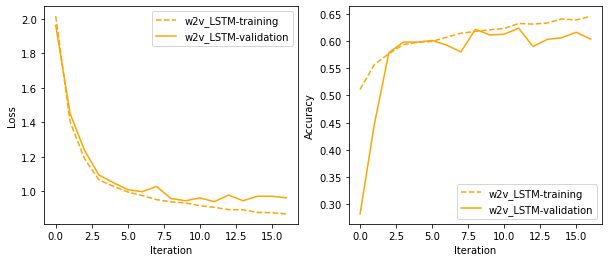

In [17]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
# plt.plot(best_lstm_history.history["loss"], label="LSTM-training", color="blue", linestyle="dashed")
# plt.plot(best_lstm_history.history["val_loss"], label="LSTM-validation", color="blue")
plt.plot(best_w2v_lstm_history.history["loss"], label="w2v_LSTM-training", color="orange", linestyle="dashed")
plt.plot(best_w2v_lstm_history.history["val_loss"], label="w2v_LSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
# plt.plot(best_lstm_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
# plt.plot(best_lstm_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.plot(best_w2v_lstm_history.history["accuracy"], label="w2v_LSTM-training", color="orange", linestyle="dashed")
plt.plot(best_w2v_lstm_history.history["val_accuracy"], label="w2v_LSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [18]:
pre = pd.DataFrame({'review_id':val_ids})
pre['stars'] = np.argmax(best_model.predict(val_feats_matrix), axis = 1) + 1
pre.to_csv('./data/w2v_lstm_pred.csv', index=False)

ans = pd.read_csv("data/valid.csv", usecols=["review_id", "stars"])
pred = pd.read_csv("data/w2v_lstm_pred.csv", usecols=["review_id", "stars"])
df = pd.merge(ans, pred, how="left", on=["review_id"])
df.fillna(0, inplace=True)
acc = accuracy_score(df["stars_x"], df["stars_y"])
p, r, f1, _ = precision_recall_fscore_support(df["stars_x"], df["stars_y"], average="macro")
print("accuracy:", acc, "\tprecision:", p, "\trecall:", r, "\tf1:", f1)

accuracy: 0.6235 	precision: 0.5026764868614256 	recall: 0.47946986574824163 	f1: 0.4597069708800044


# Bi-directional LSTM

In [20]:
np.random.seed(1)
tf.random.set_seed(1)

best_val_accuracy = 0.0
best_w2v_bi_lstm_history = None
best_model = None

for i in range(1):
#     mask1 = np.random.choice(20000,5000,replace=False) # random 5000 training sample
#     mask2 = np.random.choice(2000,400,replace=False) # random 400 training sample
    model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                      embedding_size=100, hidden_size=150, output_size=num_classes,
                      rnn_type="lstm", num_rnn_layers=1, bidirectional=True, num_mlp_layers=2,
                      embedding_matrix=embedding_matrix,
                      activation="relu",batch_norm=True,
                      learning_rate=0.002, l2_reg=0.004, dropout_rate=0.5)
    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", "w2v_bi_lstm_weights.hdf5"),
        monitor="val_accuracy",verbose=0,save_best_only=True)
    earlystopping = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1)
    word2vec_bi_lstm_history = model.fit(train_feats_matrix, train_label_matrix,
                                        epochs=100, batch_size=100, verbose=1,
                                        callbacks=[checkpointer, earlystopping],
                                     validation_data = (val_feats_matrix, val_label_matrix))
    model = keras.models.load_model(os.path.join("models", "w2v_bi_lstm_weights.hdf5"))

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                 batch_size=100)
    val_score = model.evaluate(val_feats_matrix, val_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("validation loss:", val_score[0], "validation accuracy", val_score[1])
    
    if val_score[1] > best_val_accuracy:
        best_val_accuracy = val_score[1]
        best_w2v_bi_lstm_history = word2vec_bi_lstm_history
        best_model = model

Train on 20000 samples, validate on 2000 samples
Epoch 1/100
20000/20000 [==============================] - 135s 7ms/step - loss: 1.8932 - accuracy: 0.5408 - val_loss: 1.5425 - val_accuracy: 0.5895
Epoch 2/100
20000/20000 [==============================] - 151s 8ms/step - loss: 1.2995 - accuracy: 0.5838 - val_loss: 1.3179 - val_accuracy: 0.5325
Epoch 3/100
20000/20000 [==============================] - 125s 6ms/step - loss: 1.1024 - accuracy: 0.5998 - val_loss: 1.0803 - val_accuracy: 0.5990
Epoch 4/100
20000/20000 [==============================] - 128s 6ms/step - loss: 1.0156 - accuracy: 0.6054 - val_loss: 1.0304 - val_accuracy: 0.5985
Epoch 5/100
20000/20000 [==============================] - 139s 7ms/step - loss: 0.9759 - accuracy: 0.6108 - val_loss: 1.0453 - val_accuracy: 0.5940
Epoch 6/100
20000/20000 [==============================] - 126s 6ms/step - loss: 0.9477 - accuracy: 0.6196 - val_loss: 0.9567 - val_accuracy: 0.6080
Epoch 7/100
20000/20000 [==============================] 

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(best_bi_lstm_history.history["loss"], label="Bi_LSTM-training", color="blue", linestyle="dashed")
plt.plot(best_bi_lstm_history.history["val_loss"], label="Bi_LSTM-validation", color="blue")
plt.plot(best_w2v_bi_lstm_history.history["loss"], label="w2v_Bi_LSTM-training", color="orange", linestyle="dashed")
plt.plot(best_w2v_bi_lstm_history.history["val_loss"], label="w2v_Bi_LSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(best_bi_lstm_history.history["accuracy"], label="Bi_LSTM-training", color="blue", linestyle="dashed")
plt.plot(best_bi_lstm_history.history["val_accuracy"], label="Bi_LSTM-validation", color="blue")
plt.plot(best_w2v_bi_lstm_history.history["accuracy"], label="w2v_Bi_LSTM-training", color="orange", linestyle="dashed")
plt.plot(best_w2v_bi_lstm_history.history["val_accuracy"], label="w2v_Bi_LSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
pre = pd.DataFrame({'review_id':val_ids})
pre['stars'] = np.argmax(best_model.predict(val_feats_matrix), axis = 1) + 1
pre.to_csv('./data/w2v_bi_lstm_pred.csv', index=False)

ans = pd.read_csv("data/valid.csv", usecols=["review_id", "stars"])
pred = pd.read_csv("data/w2v_bi_lstm_pred.csv", usecols=["review_id", "stars"])
df = pd.merge(ans, pred, how="left", on=["review_id"])
df.fillna(0, inplace=True)
acc = accuracy_score(df["stars_x"], df["stars_y"])
p, r, f1, _ = precision_recall_fscore_support(df["stars_x"], df["stars_y"], average="macro")
print("accuracy:", acc, "\tprecision:", p, "\trecall:", r, "\tf1:", f1)